In [1]:
from cassie import CassieEnv
import numpy as np

import time

env = CassieEnv("walking")

qpos = np.copy(env.sim.qpos())

jpos = qpos[env.pos_idx]

fbpos = qpos[0:7]

# keep feet from intersecting ground
fbpos[2] += 0.2

<IPython.core.display.Javascript object>


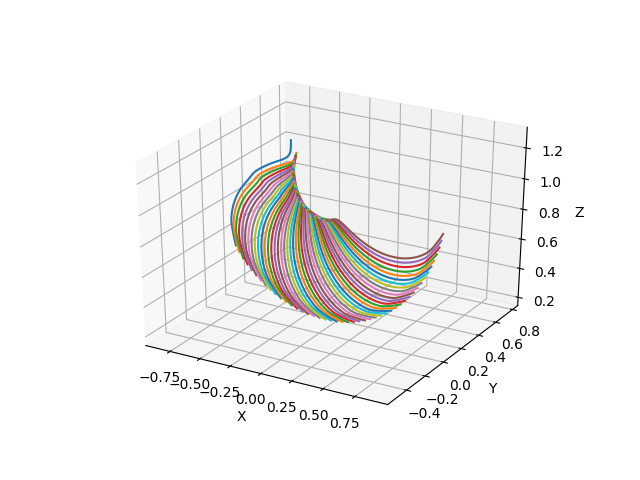

In [2]:
# Joint limits converted to radians from XML file

ROLL_LOW   = -0.26
ROLL_HIGH  =  0.39

YAW_LOW    = -0.39
YAW_HIGH   =  0.39

PITCH_LOW  = -0.87
PITCH_HIGH =  1.4

KNEE_LOW   = -2.86
KNEE_HIGH  = -0.64

FOOT_LOW   = -2.44
FOOT_HIGH  = -0.52

# achilles = .75 + pitch = 1
# not currently correct though
ACHILLES_LIMIT = 1.75

DELTA = 0.05#0.025 # resolution for IK data set
ITERS = 100#500

# ramp down joint angles
while jpos[2] > PITCH_LOW and jpos[3] > KNEE_LOW:
#     qpos = np.copy(env.sim.qpos())
#     if qpos[10] < ACHILLES_ROD_LOW:
#         print(qpos[2])
    
    jpos[2] -= DELTA
    jpos[7] -= DELTA
    
    jpos[3] -= DELTA
    jpos[8] -= DELTA
    
    env.set_joint_pos(jpos, fbpos, iters=ITERS)
    env.render()

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.axis("equal")

data = []
X = []
Y = []
Z = []

pitch = PITCH_LOW
while pitch < PITCH_HIGH:
    pitch += DELTA
    
    knee = KNEE_LOW
    while knee < KNEE_HIGH:
            knee += DELTA
            
            jpos[2] = pitch
            jpos[7] = pitch

            jpos[3] = knee
            jpos[8] = knee

            env.set_joint_pos(jpos, fbpos, iters=ITERS)
            
            footpos = np.zeros(6)
            env.sim.foot_pos(footpos)
            
            qpos = np.copy(env.sim.qpos())
            
            # get XZ foot position relative to center of mass
            footpos_relative = [footpos[0] - fbpos[0], footpos[2] - fbpos[2],
                                footpos[3] - fbpos[0], footpos[5] - fbpos[2]]
            
            data += [(footpos_relative, qpos)]
                        
            X += [footpos[0]]
            Y += [footpos[1]]
            Z += [footpos[2]]
            
            #if qpos[10] + qpos[2] < ACHILLES_LIMIT:
            #    continue 
                
            env.render()

    ax.plot(X, Y, Z)    
    X = []
    Y = []
    Z = []
    
    # ramp knee angle back down
    while jpos[3] > KNEE_LOW:
        jpos[3] -= DELTA
        jpos[8] -= DELTA
        
        env.set_joint_pos(jpos, fbpos, iters=ITERS)
        env.render()
        
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler


class MLP(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_outputs,
                 nonlinearity="tanh"):

        super(MLP, self).__init__()

        hidden_dims = (256, 256)
        
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers += [nn.Linear(num_inputs, hidden_dims[0])]
        for l in range(len(hidden_dims) - 1):
            in_dim = hidden_dims[l]
            out_dim = hidden_dims[l + 1]
            self.hidden_layers += [nn.Linear(in_dim, out_dim)]
        
        self.out = nn.Linear(hidden_dims[-1], num_outputs)
        
        if nonlinearity == "relu":
            self.nonlinearity = F.relu
        elif nonlinearity == "tanh":
            self.nonlinearity = torch.tanh
        else:
            raise NotImplementedError

    def forward(self, inputs):
        x = inputs
        for l in self.hidden_layers:
            x = self.nonlinearity(l(x))
        pred = self.out(x)
        
        return pred

x = torch.Tensor(np.array([e[0] for e in data]))
y = torch.Tensor(np.array([e[1] for e in data]))

model = MLP(4, 35)
    
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for t in range(500):
    sampler = BatchSampler(
        SubsetRandomSampler(range(y.size(0))),
        batch_size=128,
        drop_last=True
    )

    for indices in sampler:
        indices = torch.LongTensor(indices)
        
        y_batch = y[indices]
        x_batch = x[indices]

        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)

        # Compute and print loss
        loss = criterion(y_pred, y_batch)
        
        if t % 10 == 0:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


0 4987.39111328125
0 4859.623046875
0 4569.02978515625
0 4600.2587890625
0 4239.3798828125
0 4264.61083984375
0 4179.72998046875
0 4219.173828125
0 3968.055419921875
0 3885.757080078125
0 3988.658447265625
0 3811.061279296875
0 3693.666748046875
0 3751.48876953125
0 3335.31591796875
0 3520.343994140625
10 189.84521484375
10 204.91397094726562
10 192.21009826660156
10 205.70484924316406
10 166.1232452392578
10 209.17662048339844
10 199.6443328857422
10 187.69711303710938
10 203.7953338623047
10 195.90762329101562
10 191.1891632080078
10 205.52740478515625
10 210.60227966308594
10 177.7716827392578
10 175.44317626953125
10 154.2992401123047
20 94.78508758544922
20 88.7188949584961
20 94.44123077392578
20 87.31822204589844
20 97.97917175292969
20 84.34811401367188
20 77.81211853027344
20 91.0880355834961
20 83.75010681152344
20 99.78560638427734
20 98.34304809570312
20 91.0912857055664
20 85.14849853515625
20 107.34223175048828
20 72.5615234375
20 89.50877380371094
30 77.69305419921875
30

240 3.705559730529785
240 4.239781856536865
240 3.1423089504241943
240 2.95511531829834
240 4.6073222160339355
240 3.1474568843841553
240 3.3541667461395264
240 4.298682689666748
240 3.8199245929718018
240 4.410121440887451
240 4.093331336975098
240 3.1776907444000244
240 3.587916374206543
240 3.578130006790161
240 3.5596940517425537
240 3.31101655960083
250 3.9295876026153564
250 3.020299196243286
250 4.16665506362915
250 3.0386507511138916
250 3.075408697128296
250 3.9058854579925537
250 3.5248587131500244
250 3.6909549236297607
250 3.229489803314209
250 3.9355885982513428
250 3.2966301441192627
250 3.3485500812530518
250 3.95141863822937
250 3.567242383956909
250 3.5743229389190674
250 3.1665754318237305
260 3.6440680027008057
260 3.899021625518799
260 3.286067485809326
260 3.0790700912475586
260 3.090524911880493
260 4.699836254119873
260 3.553049325942993
260 3.011582136154175
260 2.805943727493286
260 3.494112014770508
260 2.990175724029541
260 3.122908592224121
260 3.40331292152

470 2.227275848388672
470 1.5873767137527466
470 1.4927171468734741
470 1.9006279706954956
470 1.7586687803268433
470 2.0682320594787598
470 1.9802478551864624
470 1.910460352897644
470 1.460828423500061
470 2.6350181102752686
470 1.0592998266220093
470 1.4609318971633911
470 1.5190327167510986
470 1.9346119165420532
470 1.858573317527771
470 1.8333406448364258
480 1.7398159503936768
480 2.4793038368225098
480 1.3790276050567627
480 2.02032732963562
480 1.9005824327468872
480 1.6899378299713135
480 1.614037036895752
480 1.3951077461242676
480 1.5885047912597656
480 1.3975670337677002
480 2.3162155151367188
480 1.7718623876571655
480 1.6937179565429688
480 1.8710784912109375
480 1.6358096599578857
480 1.527964472770691
490 1.9891184568405151
490 2.2123830318450928
490 1.6588454246520996
490 1.4812355041503906
490 1.4239364862442017
490 1.7374709844589233
490 1.2812368869781494
490 2.711286783218384
490 1.7080217599868774
490 1.5266491174697876
490 1.6352367401123047
490 1.49966192245483

700 1.0374057292938232
700 1.3524870872497559
700 0.9319408535957336
700 1.099577784538269
700 0.9910184741020203
700 1.4205691814422607
700 1.3573986291885376
700 1.2527929544448853
700 1.110399603843689
700 0.9978713393211365
700 1.429344654083252
700 1.1932079792022705
700 1.535817265510559
700 0.9888856410980225
700 1.1989126205444336
700 1.533812403678894
710 0.7038378119468689
710 1.4303574562072754
710 1.4122979640960693
710 0.894814133644104
710 1.3703174591064453
710 1.2611908912658691
710 1.294154405593872
710 0.7606961131095886
710 0.799281895160675
710 0.9219033122062683
710 1.2872517108917236
710 0.9062901735305786
710 0.9340481162071228
710 1.431935429573059
710 0.8364925980567932
710 2.559779167175293
720 0.7003283500671387
720 0.9139571189880371
720 1.1102991104125977
720 1.1239995956420898
720 1.251090168952942
720 1.9339185953140259
720 1.3882259130477905
720 0.9130576252937317
720 1.0827299356460571
720 1.5143632888793945
720 1.2916629314422607
720 0.8561012148857117

940 1.0693724155426025
940 0.8266700506210327
940 1.036371111869812
940 1.5224199295043945
940 0.8482773303985596
940 1.1868524551391602
940 0.6339852213859558
940 0.997065544128418
940 1.3319330215454102
940 0.9668334722518921
940 0.7693077921867371
940 1.131291389465332
940 0.9573236703872681
940 1.2657264471054077
940 0.9865896105766296
940 0.7393587827682495
950 0.7228855490684509
950 0.594595193862915
950 0.8360939621925354
950 1.3136996030807495
950 1.1205198764801025
950 0.8816230893135071
950 1.421958327293396
950 0.6692566871643066
950 0.5689430832862854
950 1.2302873134613037
950 1.0176202058792114
950 1.259045124053955
950 0.9308856129646301
950 1.4315279722213745
950 1.1242389678955078
950 0.9490129351615906
960 0.7891300916671753
960 1.0750592947006226
960 0.9667839407920837
960 1.2242237329483032
960 1.5203934907913208
960 1.0240954160690308
960 0.5931261777877808
960 1.249587059020996
960 0.7397269010543823
960 0.7900505065917969
960 1.2638477087020874
960 1.224252820014

In [14]:
fpos_des = x_batch[3]

qpos = model(fpos_des)

print(fpos_des)
qpos = qpos.detach().numpy()

fbpos[2] += 0.5

fbpos[]

qpos[0:7] = fbpos


from cassie.cassiemujoco import pd_in_t
env.sim.set_qpos(qpos)
env.sim.step_pd(pd_in_t())
env.render()

tensor([-0.1907, -0.7742, -0.1907, -0.7742])


### 